# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np

In [2]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    
    if save:
        plt.savefig(name, format= 'png')

## Creating artificial data

In [3]:
size = 3
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 3*np.ones(size)

#I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
#Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
#Cx = np.clip(Cx,0,IMAGE_SIZE_X)
#Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
#Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

I = np.array([1, 1, 1])
Cx = np.array([25, 40, 10])
Cy = np.array([25, 30, 10])

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 1 at (25,25)
max I: 1 at (25,25)



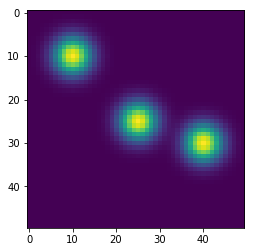

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *
%matplotlib inline

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.savefig('img_sinthc.png', format='png')

img = Im_sinthc #rename variable

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

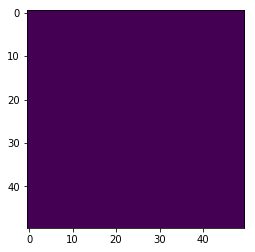

In [6]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'ALL'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

[  1.16253284e-07   1.13412479e-08]
(1.16253284006e-07+1.13412479385e-08j)


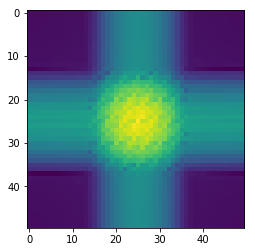

In [7]:
measurements,U,V = UVCreator(np.fft.fftshift(img_fft),mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs, shift=False)

print(V[1,:])
#print(U)
print(measurements[0,1])

In [8]:
allIndex = np.arange(V.shape[0])
numberOfSamplings = np.ceil(V.shape[0]*0.7).astype(int)
sampledIndex = np.random.choice(allIndex, numberOfSamplings)
allV = V
allU = U

cov = np.array([[0.02, 0.0002],[0.0002, 0.02]])
m = np.zeros(2)

V = allV[sampledIndex,:] + np.random.multivariate_normal(m,cov)
U = allU[sampledIndex,:] + np.random.multivariate_normal(m,cov)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [9]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,C, factor = None, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
    # We have implemented the model defined by:
    # V_obs = sum_{i=0}^{N_BASIS} alpha_i phi_i(u,v)
    # where phi_i(u,v) = exp(-2pi(u^2+v^2)l^2)exp(-j2pi(Cx^i u + Cv^i v))
    
    if factor == None:
        factorY= IMAGE_SIZE_Y
        factorX= IMAGE_SIZE_X
    
    # Rescale u,v space
    Uaux = U.astype('float32')
    
    Uaux[:,1] = U[:,1] - IMAGE_SIZE_X/2
    Uaux[:,1] = Uaux[:,1]/factorX
    Uaux[:,0] = U[:,0] - IMAGE_SIZE_Y/2
    Uaux[:,0] = Uaux[:,0]/factorY
#     print(u_aux)
    
    # Amplitud (Mantle o carrier)
    A = tt.exp(-2*np.pi**2*(tt.mul(Uaux,Uaux).sum(axis=1)*tt.pow(l[:,np.newaxis],2)))
#     A   = tt.outer(A_u,A_v)
#     print(A.eval().shape)
#     print(A.shape)
    
    # Imaginary Exponential (Mudolator)
    cosPart = tt.cos(-2*np.pi*tt.dot(C,Uaux.T))
    sinPart = tt.sin(-2*np.pi*tt.dot(C,Uaux.T))
#     print(cosPart.eval().shape)
#     imagExp = tt.exp(-2*np.pi*1j*(C*Uaux))
#     ## This is a outer multiplication between column's matrix
#     imagExp   = imagExp_u.dimshuffle(0, 1, 'x') * imagExp_v.dimshuffle(0, 'x', 1)
#     print(imagExp.eval().shape)
    
#     print((alpha*A*imagExp).eval().shape)
    ## Finally, alpha_i * phi_i
    out_real = (alpha[:,np.newaxis]*A*cosPart).sum(axis = 0)
    out_imag = (alpha[:,np.newaxis]*A*sinPart).sum(axis = 0)
#     out_real = tt.real(tt.sum(alpha[:,np.newaxis]*A*imagExp, axis = 0))
#     out_imag = tt.imag(tt.sum(alpha[:,np.newaxis]*A*imagExp, axis = 0))
    
#     print(imagExp.shape)


# print(cosPart.shape, sinPart.shape)    
    return out_real, out_imag

(0.0723285652873+0.00291384384835j)


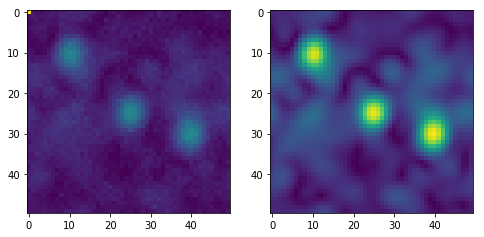

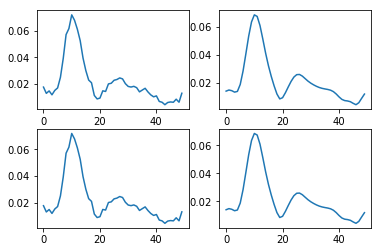

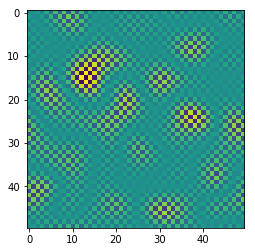

In [10]:
from scipy import ndimage

numberOfSamplings = U.shape[0]
numberOfBasis = size

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_C = np.stack([Cy,Cx], axis = 1)
# print(init_C.shape)
init_U = U.astype(int)

u1 = np.arange((100))
v1 = np.arange((100))

myU = np.zeros((u1.shape[0]*v1.shape[0],2), dtype=np.int)
k = 0
for i in range(u1.shape[0]):
    for j in range(v1.shape[0]):
        myU[k,0] = u1[i]
        myU[k,1] = v1[j]
        k += 1

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_C,
                               IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y= IMAGE_SIZE_Y)

def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
#     print(U.shape[0])
#     print(V_real.shape[0])
#     print(V_imag.shape[0])
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
Im_pix = np.fft.ifft2(Im_pix_fft)
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(8)
ax[0].imshow( np.abs(Im_pix) )
print(np.max(Im_pix))

Im_ind_real, Im_ind_imag = matrix_points(init_U,PHI_Re.eval(), PHI_Im.eval(), IMAGE_SIZE_X=IMAGE_SIZE_X ,IMAGE_SIZE_Y=IMAGE_SIZE_Y)

#Im_ind_real = ndimage.rotate(Im_ind_real, 90*2)
#Im_ind_imag = ndimage.rotate(Im_ind_imag, 90*2)
# Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
# print(Im_ind_fft.shape)
Im_ind = np.fft.ifft2(Im_ind_fft)
#Im_ind = np.fft.fftshift(Im_ind)
ax[1].imshow( np.abs(Im_ind) )
# print(np.max(Im_ind))

fig, ax = plt.subplots(2,2)
ax[0,0].plot(np.abs(Im_pix[:,10]))
ax[0,1].plot(np.abs(Im_ind[:,10]))
ax[1,0].plot(np.abs(Im_pix[:,10]))
ax[1,1].plot(np.abs(Im_ind[:,10]))
plt.show()


plt.imshow(Im_ind.real)
plt.imshow(Im_ind.imag)


In [11]:
#from scipy import optimize
numberOfSamplings = U.shape[0]
numberOfBasis = 10
rbf_model = pm.Model()


l = 3*np.ones(numberOfBasis)
# init_Cx = IMAGE_SIZE_X*np.random.rand(numberOfBasis)
# init_Cy = IMAGE_SIZE_Y*np.random.rand(numberOfBasis)
init_C = np.array([IMAGE_SIZE_Y,IMAGE_SIZE_X])/2
init_sigma = 10*np.array([[1,1],[1,2]])

beta_0 = 0.5
C_sd = IMAGE_SIZE_X/3
alpha_sd = 10

with rbf_model:
    alpha_s = pm.HalfNormal('alpha_s', sd=alpha_sd, shape = numberOfBasis)
    alpha_model = pm.Normal('alpha', mu=0, sd=1./alpha_s, shape = numberOfBasis)
    
#     Cx_model = pm.Gamma('Cx', alpha=beta_0*(init_Cx)+1, beta=beta_0, shape = numberOfBasis)
#     Cy_model = pm.Gamma('Cy', alpha=beta_0*(init_Cy)+1, beta=beta_0, shape = numberOfBasis)
#     Cx_model = pm.Normal('Cx', mu=IMAGE_SIZE_X/2, sd=C_sd, shape = numberOfBasis)
#     Cx_model = pm.Uniform('Cx', lower=0, upper=IMAGE_SIZE_X, shape = numberOfBasis)
#     Cy_model = pm.Normal('Cy', mu=IMAGE_SIZE_Y/2, sd=C_s, shape = numberOfBasis)
#     Cy_model = pm.Uniform('Cy', lower=0, upper=IMAGE_SIZE_Y, shape = numberOfBasis)
    C_model = pm.Normal('C', mu=init_C, sd=C_sd, shape = (numberOfBasis,2))

    l_model = pm.Gamma('l', alpha = beta_0*l+2, beta=beta_0, shape = numberOfBasis)

    sd_dist = pm.Normal.dist(0,0.1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    sigma_model = tt.dot(chol, chol.T)
    
#     sigma_model = pm.Lognormal('sigma', init_sigma, np.ones(2), shape=(2,2), testval=init_sigma)

    PHI_Re, PHI_Im = Vobs_function(init_U, l_model, alpha_model, C_model,
                                   IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)

    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed= V)
    
#     db = pm.backends.Text('test_log_normal')
#     n_samples = 1000
    
#     step = pm.Metropolis(vars=[alpha_model, Cx_model, Cy_model,l_model])
#     step = pm.Slice()
#     step = pm.NUTS()
#     trace = pm.sample(n_samples, step)
    estimation = pm.find_MAP()
    print(estimation)

         Current function value: -9960.237343
         Iterations: 1406
         Function evaluations: 1696
         Gradient evaluations: 1683
{'alpha_s_log__': array([-1.67072981,  2.64910841,  2.64818934, -1.6709196 ,  2.64909238,
       -1.6778184 ,  2.52699377,  2.64912171,  2.64882926,  2.64751138]), 'alpha': array([  7.51735946e+00,   1.00246443e-03,   4.40519540e-03,
         7.51878645e+00,   1.15170956e-03,   7.57084558e+00,
        -5.26084964e-02,   8.60225327e-04,  -2.56733317e-03,
        -5.74458477e-03]), 'C': array([[ 30.0000281 ,  39.99949329],
       [ 22.30582098,  29.69182973],
       [ 20.05331219,  49.39997377],
       [ 10.00012064,   9.99956508],
       [ 39.85552797,  50.95569144],
       [ 25.01576585,  24.99539203],
       [ 27.02951455,  24.75448772],
       [ 29.88735266,   1.55834349],
       [ -1.84407811,  59.14863987],
       [ 26.16709483,  22.28839036]]), 'l_log__': array([ 1.09842709,  0.53550662,  0.24696278,  1.09843722,  0.10747056,
        1.098

Asegurarme de que los parámetros reales son un máximo de la posterior.

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

Initial Conditions:
Number of Basis: 10; Number of Samplings: 1750
Cx,Cy: [[ 30.0000281   39.99949329]
 [ 22.30582098  29.69182973]
 [ 20.05331219  49.39997377]
 [ 10.00012064   9.99956508]
 [ 39.85552797  50.95569144]
 [ 25.01576585  24.99539203]
 [ 27.02951455  24.75448772]
 [ 29.88735266   1.55834349]
 [ -1.84407811  59.14863987]
 [ 26.16709483  22.28839036]]; 
alpha: [  7.51735946e+00   1.00246443e-03   4.40519540e-03   7.51878645e+00
   1.15170956e-03   7.57084558e+00  -5.26084964e-02   8.60225327e-04
  -2.56733317e-03  -5.74458477e-03]; 
l: [ 2.99944445  1.70831349  1.28013147  2.99947485  1.11345808  2.99992589
  2.76489438  0.6424146   2.27352679  2.22843145]
[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 ..., 
 [ 49.  47.]
 [ 49.  48.]
 [ 49.  49.]]
(0.0723285652873+0.00291384384835j)
-0.000136785634374 0.000520864801672
(0.0723285652873+0.00291384384835j)
(0.0723285652873+0.00291384384835j)
(0.0723285652873+0.00291384384835j)


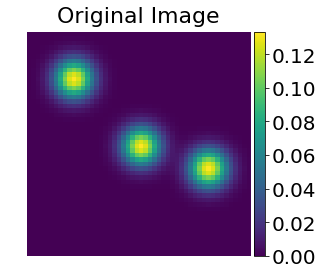

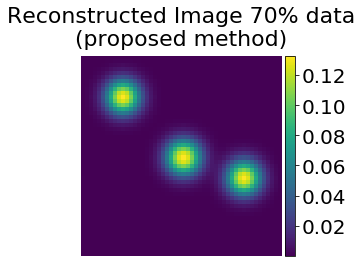

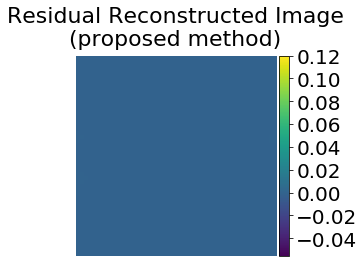

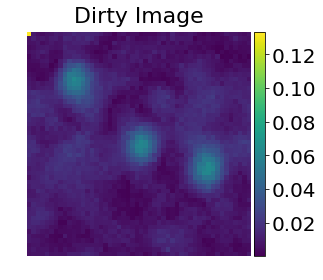

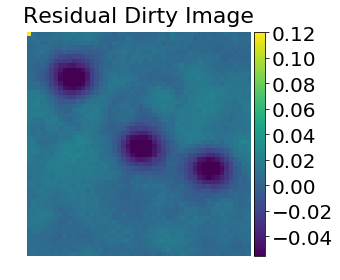

In [13]:
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( Im_sinthc , cmap='viridis' )
ax.set_title('Original Image', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
plt.tight_layout()
#plt.savefig('imagen_original.pdf', format='pdf')


alpha_test_half = estimation['alpha']
C_test_half = estimation['C']
l_test_half = np.exp(estimation['l_log__'])

print('Initial Conditions:')
print('Number of Basis: %s; Number of Samplings: %s' % (numberOfBasis, numberOfSamplings))
print('Cx,Cy: %s; ' % (C_test_half)),
print('alpha: %s; ' % (alpha_test_half)),
print('l: %s' % l_test_half)


PHI_Re, PHI_Im = Vobs_function(allU, l_test_half, alpha_test_half, C_test_half,
                                   IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)

print(allU)
Im_ind_real, Im_ind_imag = matrix_points(allU,PHI_Re.eval(), PHI_Im.eval(),
                                         IMAGE_SIZE_X= 50, IMAGE_SIZE_Y=50)
Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
Im_ind = np.fft.ifft2(Im_ind_fft)

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.abs(Im_ind) , cmap='viridis' )
ax.set_title('Reconstructed Image 70% data\n(proposed method)', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
print(np.max(Im_pix))
plt.tight_layout()
#plt.savefig('imagen_reconstruction-70.pdf', format='pdf')


fig = plt.figure()
ax = plt.gca()
I_res = (np.abs(Im_ind) -  Im_sinthc)
print(np.min(I_res), np.max(I_res))
im = ax.imshow(I_res , cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Reconstructed Image\n(proposed method)', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
print(np.max(Im_pix))

plt.tight_layout()
#plt.savefig('imagen_reconstruction-70_dif.pdf', format='pdf')


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1],
                                         IMAGE_SIZE_X= IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
Im_pix = np.fft.ifft2(Im_pix_fft)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(Im_sinthc)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) , cmap='viridis' )
ax.set_title('Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
print(np.max(Im_pix))

plt.tight_layout()
#plt.savefig('imagen_dirty-70.pdf', format='pdf')

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(Im_sinthc)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) - Im_sinthc, cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
print(np.max(Im_pix))

plt.tight_layout()
#plt.savefig('imagen_dirty-70-dif.pdf', format='pdf')

In [14]:
print(np.sum((np.abs(Im_ind) -  Im_sinthc)**2) )

3.76992694989e-06


In [15]:
print(np.sum((np.max(Im_sinthc)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) -  Im_sinthc)**2) )

0.646137530611
